# DBQA GCI Circuit Synthesis

Variational quantum eigensolver (VQE) is commonly used for ground state preparation. In this notebook, we demonstrate how to use a few steps of double-bracket quantum algorithms (DBQAs) to enhance the performance of VQE.

To achieve this, we use the `qibo` package [1] to first train a warm-start VQE circuit, and from there, run a few steps of DBQAs [2] realized by group commutator iterations (GCIs) [3].

Then, the final circuit may be converted into `qiskit` or `pytekt` compatible formats for running on emulators or quantum hardwares.

[1] https://github.com/qiboteam/qibo

[2] M. Gluza, “Double-bracket quantum algorithms for diagonalization,” Quantum, vol. 8, p. 1316, Apr. 2024, doi: 10.22331/q-2024-04-09-1316. https://arxiv.org/abs/2206.11772 

[3] M. Robbiati et al., “Double-bracket quantum algorithms for high-fidelity ground state preparation,” Aug. 07, 2024, arXiv: arXiv:2408.03987. doi: 10.48550/arXiv.2408.03987.https://arxiv.org/abs/2408.03987

In this example notebook, we perform numerical simulations of DBQA for the XXZ model with a periodic boundary condition, whose hamiltonian is given by:

$$
H_0 = \sum _{k=0}^L \left( X_{k} X_{k + 1} + Y_{k} Y_{k + 1} + \delta Z_{k}Z_{k + 1} \right)
$$

In [36]:
import qibo
from qibo.backends import construct_backend
from qibo import hamiltonians
import matplotlib.pyplot as plt
import numpy as np
from boostvqe.models.dbi.double_bracket_evolution_oracles import XXZ_EvolutionOracle, FrameShiftedEvolutionOracle
from boostvqe.models.dbi.group_commutator_iteration_transpiler import *
from boostvqe.utils import select_recursion_step_gd_circuit
import time

ModuleNotFoundError: No module named 'qiboml'

In [2]:
qibo.set_backend("tensorflow")
vqe_backend = construct_backend(backend="tensorflow")

[Qibo 0.2.12|INFO|2025-01-24 08:36:49]: Using tensorflow backend on /device:CPU:0


[Qibo 0.2.12|WARNING|2025-01-24 08:36:49]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


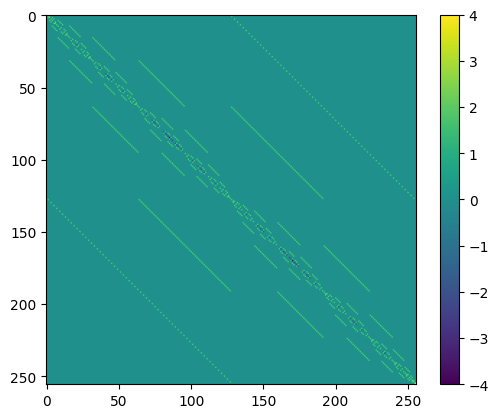

In [3]:
nqubits = 8
delta = 0.5
ham = hamiltonians.XXZ(nqubits, delta, dense=False)
plt.imshow(np.real(ham.matrix))
plt.colorbar()

## Step 1: train VQE (optional)
We define the loss function to be the energy expectation $\langle H\rangle$.
The following cells contain the complete process of VQE training using Qibo.
While the user can modify the code and train their VQE, this section is optional if you wish to load from existing results, for which, proceed to step 2.

In [4]:
from boostvqe import ansatze
from copy import deepcopy
from functools import partial
from boostvqe.training_utils import vqe_loss
from boostvqe.utils import *

/Users/pethidine/Library/Caches/pypoetry/virtualenvs/boostvqe-9Q-2T4PW-py3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# helper functions
def exact_expectation_boost(ham, circ):
    # calculates the exact expectation of hamiltonian given a circuit in qibo
    return ham.expectation(
        ham.backend.execute_circuit(circuit=circ).state())

In [17]:
# build ansatz circuit
nlayer = 1
ansatz_circ = ansatze.hdw_efficient(nqubits, nlayer)
print(ansatz_circ.draw())

NameError: name 'ansatze' is not defined

In [7]:
# build zero state
zero_state = ham.backend.zero_state(nqubits)
# initial params
params_len = len(ansatz_circ.get_parameters())
# fix numpy seed to ensure replicability of the experiment
seed = 10
np.random.seed(seed)
initial_params = np.random.uniform(-np.pi, np.pi, params_len)
print('Initial parameters:', initial_params)
# initial energy
c0 = deepcopy(ansatz_circ)
c0.set_parameters(initial_params)
target_energy = np.real(np.min(np.asarray(ham.eigenvalues())))
print('Target enegry:', target_energy)
print('Initial energy:', exact_expectation_boost(ham, c0).numpy())
print('Net difference:', exact_expectation_boost(ham, c0).numpy()-target_energy)

Initial parameters: [ 1.70475788 -3.01120431  0.83973663  1.5632809  -0.00938072 -1.72915367
 -1.89712697  1.63696274 -2.07903793 -2.58653723  1.16465009  2.84875441
 -3.11678496  0.07660625  1.96425543  0.70702213  1.39332975 -1.30768123
  2.62495223  1.34821941  0.26731415 -2.2483119  -0.79582348  1.09411377
 -0.36547294 -0.41460231  0.73995175  0.08255001  0.94497336  0.63484647
  1.91777391  0.13601307  2.56761664 -1.13577315 -2.5732198  -1.25223848
 -2.42540779  2.06516568 -2.84693439  0.79348555]
Target enegry: -12.347977420549542
Initial energy: 0.06942551412501358
Net difference: 12.417402934674556


In [8]:
# define the qibo loss function
objective_boost = partial(vqe_loss)
# logging hisotry
params_history, loss_history, grads_history, fluctuations = [], [], [], []
# set optimizer
optimizer = 'sgd'
maxiter = 1500
nmessage = 500
learning_rate = 5e-2
tol = 1e-5 # for `sgd` this is required but not used
params_history.append(initial_params)

### Train VQE

In [9]:
param = params_history[-1]
(
    partial_results,
    partial_params_history,
    partial_loss_history,
    partial_grads_history,
    partial_fluctuations,
    vqe,
) = train_vqe(
    deepcopy(ansatz_circ),
    ham,  # Fixed hamiltonian
    optimizer,
    param,
    tol=tol,
    niterations=maxiter, # Show log info
    nmessage=nmessage,
    loss=objective_boost,
    training_options={'nepochs': maxiter,
                      'learning_rate': learning_rate,}
)
params_history.extend(np.array(partial_params_history))
loss_history.extend(np.array(partial_loss_history))
grads_history.extend(np.array(partial_grads_history))
fluctuations.extend(np.array(partial_fluctuations))

INFO:root:Optimization iteration 0/1500
INFO:root:Loss 0.069426
INFO:root:Minimize the energy
[Qibo 0.2.12|INFO|2025-01-10 15:47:40]: ite 1 : loss -0.543037
INFO:qibo.config:ite 1 : loss -0.543037
INFO:root:Optimization iteration 500/1500
INFO:root:Loss -10.551
INFO:root:Optimization iteration 1000/1500
INFO:root:Loss -10.572
[Qibo 0.2.12|INFO|2025-01-10 15:52:03]: ite 1001 : loss -10.571944
INFO:qibo.config:ite 1001 : loss -10.571944
INFO:root:Optimization iteration 1500/1500
INFO:root:Loss -10.579


In [10]:
import os
folder_path = f'results/vqe_training/{optimizer}_{nqubits}q_{nlayer}l_XXZ'
os.makedirs(folder_path, exist_ok=True)
path_param = folder_path + f'/vqe_params_hist_{nqubits}.npy'
path_loss = folder_path + f'/vqe_loss_hist_{nqubits}.npy'
np.save(path_param, params_history)
np.save(path_loss, loss_history)

## Step 2: load VQE results
We load the saved VQE training results from '.npy' files.

In [4]:
# Training params must be provided if loading directly from file, 
# otherwise comment out the following 2 lines
optimizer = 'sgd'
nlayer = 1
# load from the results/vqe_training folder
import os
folder_path = f'results/vqe_training/{optimizer}_{nqubits}q_{nlayer}l_XXZ/'
os.makedirs(folder_path, exist_ok=True)
path_param = folder_path + f'vqe_params_hist_{nqubits}.npy'
path_loss = folder_path + f'vqe_loss_hist_{nqubits}.npy'

In [5]:
vqe_params = np.load(path_param)
loss_history = np.load(path_loss)

Text(0.5, 1.0, 'VQE training with 1 layer(s)')

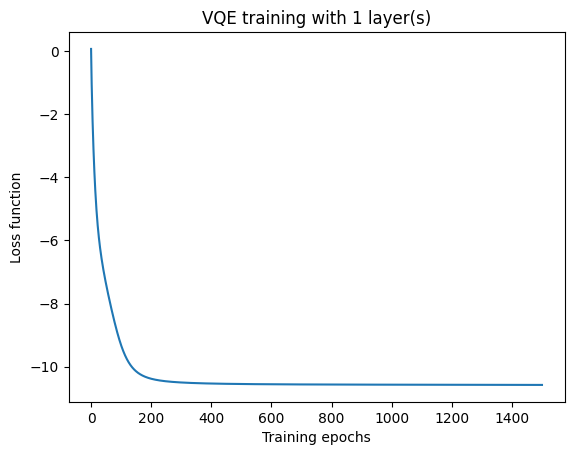

In [6]:
# plot the learning curve
plt. plot(loss_history)
plt.xlabel('Training epochs')
plt.ylabel('Loss function')
plt.title(f'VQE training with {nlayer} layer(s)')

We can compare the parameters:

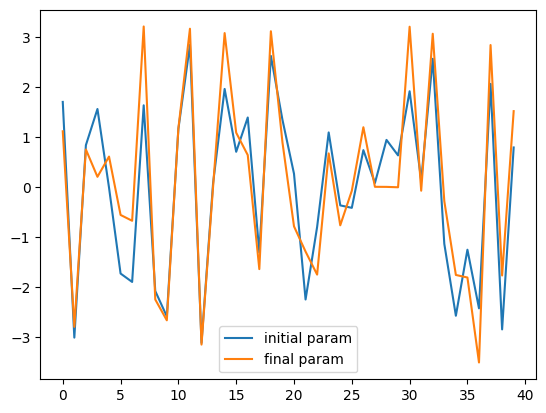

In [7]:
plt.plot(vqe_params[0], label='initial param')
plt.plot(vqe_params[-1], label='final param')
plt.legend()

We take the last set of parameters as the result of our VQE training and from there build our trained VQE circuit.

In [15]:
vqe_param_final = vqe_params[-1]
ansatz_circ.set_parameters(vqe_param_final)
vqe_circ = ansatz_circ

NameError: name 'ansatz_circ' is not defined

## Step 3: GCI DBQA

### Double-bracket rotation

A double-bracket rotation is given by
$$
H_{k+1} = e^{s_kW_k}H_ke^{-s_kW_k}
$$
where $s$ is the rotation duration, the rotation generator $W_k:=[D_k, H_k]$, and $D_k$ is a diagonal operator. While it is possible to use a fixed $s$ and fixed $D$ for all iterations, variational strategies have been proposed [1] to improve the training efficiency. 

In this minimal example, we use the magnetic field parameterization for $D$, which considers a local magnetic field in the $z$-direction

$$
D_k(B^{(k)})=\sum_{j=1}^L \alpha_j^{(k)}Z_j,
$$

and we can use gradient descent to optimize the values of $\alpha_j^{(k)}$.

### Frame-shifted oracle
Since we have a warm-start VQE circuit $Q$, we address the problem of preparing the ground state of the input Hamiltonian $H_0$ by considering a frame-shifted $A_0 = Q^\dagger H_0 Q$. We would then have
$$
E^{(k)}=\langle \psi_k|H_0|\psi_k\rangle = \langle 0|A_{k+1}|0\rangle.
$$
Thus this warm-start mechanism allows us to interface VQE and DBQA by defining a common cost function.

### Group commutator iteration
In a group commutator iteration (GCI), we have $$J_{k+1}= U_k^\dagger J_k U_k$$
which is obtained by a product formula for $U_k$ [2].
We will use two examples
$$P_k = e^{is D_k} e^{is J_k} e^{-isD_k}$$
and
$$Q_k = e^{-is J_k}e^{is D_k} e^{is J_k} e^{-isD_k}$$

We can show that
$$J_{k+1}= P_k^\dagger J_k P_k= Q_k^\dagger J_k Q_k$$
because of a reduction by means of a commutator vanishing (the ordering was chosen on purpose).

This means that the group commutator $P_k$ and the reduced $Q_k$ schemes should give the same `GroupCommutatorIterationWithEvolutionOracles.h`. Additionally that should be also `DoubleBracketIteration.h` as long as the ordering is correct.

[1] L. Xiaoyue et al., “Strategies for optimizing double-bracket quantum algorithms,” Aug. 14, 2024, arXiv: arXiv:2408.07431. doi: 10.48550/arXiv.2408.07431. https://arxiv.org/abs/2408.07431 

[2] Y.-A. Chen, A. M. Childs, M. Hafezi, Z. Jiang, H. Kim, and Y. Xu, “Efficient product formulas for commutators and applications to quantum simulation,” Phys. Rev. Research, vol. 4, no. 1, p. 013191, Mar. 2022, doi: 10.1103/PhysRevResearch.4.013191. https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.4.013191 

### GCI procedure
We describe the procedure for preparing a GCI circuit:

1. Initialize base oracle evolution oracle of the input Hamiltonian: it outputs circuits that performs $e^{-itH_0}$; we use Trotter-Suzuki and then recompile the 2 qubit unitaries into CNOT; evolution oracles are data structures to keep track of how the Hamiltonian simulation is done, it should output a circuit which will be used whenever DBQA needs to run the evolution governed by the input Hamiltonian $H_0$

2. Generate the frame-shifted evolution oracle: compose the VQE circuit $Q$ with the base oracle to get $A_0=Q^\dagger H_0 Q$ as the new Hamiltonian to train GCI on

3. Initialize the GCI: determine the group commutator approximation and define the parameterization for $D_k$. 

Using the magnetic field parameterization will use no CZ gates and will give qualitatively similar results. We recommend this in presence of noise, especially for the early steps when running more DBQA steps

In [20]:
folder_path = f'results/circuit_qasm/{optimizer}_{nqubits}q_{nlayer}l_XXZ/'
vqe_circ_file = folder_path + 'vqe_circ.qasm'
with open(vqe_circ_file, 'r') as file:
    vqe_qasm_str = file.read()
vqe_circ = qibo.Circuit.from_qasm(vqe_qasm_str)

In [21]:
# steps (int): Number of time steps (default 1).
# order (int): the order of product formula, as of now, it takes value 1 or 2.
base_oracle = XXZ_EvolutionOracle.from_nqubits(
    nqubits=nqubits, delta=0.5, steps=1, order=1
)
# the following circuit performs exp{-0.01iH}
base_circ = base_oracle.circuit(t_duration=0.01)
print(base_circ.draw())

[Qibo 0.2.12|WARNING|2025-01-24 08:47:07]: Starting on qibo 0.2.13, ``Circuit.draw`` will work in-place. The in-place method is currently implemented as ``Circuit.display``, but will be renamed as ``Circuit.draw`` on release 0.2.13. In release 0.2.12, the in-place display of circuits is accessible as ``Circuit.display``.


q0:     ────X───────RZ─o──────────X───────RZ─RZ───────o─RY───────X─RY───────o─ ...
q1:     ─RZ─o───────RY─X───────RY─o─────────────X─────|─RZ─o─────|────X─────|─ ...
q2:     ──────X─────RZ───o──────────X─────RZ─RZ─o─────|─RY─X─────|─RY─o─────|─ ...
q3:     ─RZ───o─────RY───X─────RY───o─────────────X───|─RZ───o───|──────X───|─ ...
q4:     ────────X───RZ─────o──────────X───RZ─RZ───o───|─RY───X───|─RY───o───|─ ...
q5:     ─RZ─────o───RY─────X───RY─────o─────────────X─|─RZ─────o─|────────X─|─ ...
q6:     ──────────X─RZ───────o──────────X─RZ─RZ─────o─|─RY─────X─|─RY─────o─|─ ...
q7:     ─RZ───────o─RY───────X─RY───────o─────────────X─RZ───────o──────────X─ ...

q0: ... ───
q1: ... RZ─
q2: ... ───
q3: ... RZ─
q4: ... ───
q5: ... RZ─
q6: ... ───
q7: ... RZ─


In [23]:
frame_oracle = FrameShiftedEvolutionOracle.from_evolution_oracle(
    before_circuit=vqe_circ,
    after_circuit=vqe_circ.invert(),
    base_evolution_oracle=base_oracle,
)

In [26]:
# db_rotation = DoubleBracketRotationType.group_commutator_third_order_reduced
dbr_type = DoubleBracketRotationType.group_commutator_reduced
gci = GroupCommutatorIterationWithEvolutionOracles(
        frame_oracle,
        dbr_type
    )

In [29]:
eo_d_type = MagneticFieldEvolutionOracle
print(
        f"The gci mode is {gci.double_bracket_rotation_type} rotation with {eo_d_type.__name__} as the oracle.\n"
    )

The gci mode is DoubleBracketRotationType.group_commutator_reduced rotation with MagneticFieldEvolutionOracle as the oracle.



In [30]:
# GCI settings
steps = 1
optimization_method = "sgd"
gd_epochs = 20
opt_options = {'gd_epochs':gd_epochs, }

In [34]:
for gci_step_nmb in range(steps):
    print(
        "\n################################################################################\n"
        + f"Optimizing GCI step {gci_step_nmb+1} with optimizer {optimization_method}"
        + "\n################################################################################\n"
    )
    it = time.time()
    if optimization_method == optimization_method:
        params = (
            [4 - np.sin(x / 3) for x in range(nqubits)]
            if eo_d_type == MagneticFieldEvolutionOracle
            else [4 - np.sin(x / 3) for x in range(nqubits)] + nqubits * [1]
        )
        mode, best_s, best_b, eo_d = select_recursion_step_gd_circuit(
            gci,
            mode=dbr_type,
            eo_d_type=eo_d_type,
            params=params,
            step_grid=np.linspace(1e-5, 2e-2, 30),
            lr_range=(1e-3, 1),
            nmb_gd_epochs=gd_epochs,
            threshold=1e-4,
            max_eval_gd=30,
        )

        opt_dict = {"sgd_extras": "To be defined"}

    else:
        if gci_step_nmb == 0:
            p0 = [0.01]
            if eo_d_type == MagneticFieldEvolutionOracle:
                p0.extend([4 - np.sin(x / 3) for x in range(nqubits)])
            elif eo_d_type == IsingNNEvolutionOracle:
                p0.extend(
                    [4 - np.sin(x / 3) for x in range(nqubits)] + nqubits * [1]
                )

        else:
            p0 = [best_s]
            p0.extend(best_b)
        optimized_params, opt_dict = optimize_D(
            params=p0,
            gci=gci,
            eo_d_type=eo_d_type,
            mode=dbr_type,
            method=optimization_method,
            **opt_options,
        )
        best_s = optimized_params[0]
        best_b = optimized_params[1:]
        eo_d = eo_d_type.load(best_b)

    step_data = dict(
        best_s=best_s,
        eo_d_name=eo_d.__class__.__name__,
        eo_d_params=eo_d.params,
    )
    logging.info(f"Total optimization time required: {time.time() - it} seconds")
    gci.mode_double_bracket_rotation = dbr_type

    gci(best_s, eo_d, dbr_type)



################################################################################
Optimizing GCI step 1 with optimizer sgd
################################################################################



NameError: name 'select_recursion_step_gd_circuit' is not defined

In [29]:
print(best_s)

0.02


### Result analysis

In this analysis, we will look at the following attributes:

1. Fidelity
$$
F(\rho, \sigma) = \text{tr}^{2}\left( \sqrt{\sqrt{\sigma}
        \rho^{\dagger}\sqrt{\sigma}} \right)
$$
in our case, we are comparing the approximated ground state of our hamiltonian $|\psi_k\rang=U_k|0\rang=V_k...V_0Q|0\rang$ and its analytical ground state. Note that when $L$ is odd, the ground states are degenerate, which can lead to wrong fidelity values.

2. Fidelity witness [1]
Fidelity witness is an experimentally-friendly measure to find the closeness between a target pure state $|\phi\rang$ and an experimental/simulated state $\rho$. It provides a lower bound for the fidelity.
Specifically,
$$ 1-|Tr(H_0\rho)-\lang\phi|H_0|\phi\rang|/\Delta \le F(|\phi\rang, \rho),
$$
where $\Delta$ is the first energy gap of the input Hamiltonian $H_0$.

[1] M. Gluza, M. Kliesch, J. Eisert, and L. Aolita, “Fidelity Witnesses for Fermionic Quantum Simulations,” Phys. Rev. Lett., vol. 120, no. 19, p. 190501, May 2018, doi: 10.1103/PhysRevLett.120.190501. https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.120.190501 

In [22]:
from qibo.quantum_info.metrics import fidelity

In [23]:
def report(vqe_circ, hamiltonian, gci, step, eo_d, mode):
    energies = hamiltonian.eigenvalues()
    ground_state_energy = float(energies[0])
    vqe_energy = float(hamiltonian.expectation(vqe_circ().state()))
    gci_loss = float(gci.loss(step, eo_d, mode))
    gap = float(energies[1] - energies[0])

    return (
        dict(
            nqubits=hamiltonian.nqubits,
            gci_loss=float(gci_loss),
            vqe_energy=float(vqe_energy),
            target_energy=ground_state_energy,
            diff_vqe_target=vqe_energy - ground_state_energy,
            diff_gci_target=gci_loss - ground_state_energy,
            gap=gap,
            diff_vqe_target_perc=abs(vqe_energy - ground_state_energy)
            / abs(ground_state_energy)
            * 100,
            diff_gci_target_perc=abs(gci_loss - ground_state_energy)
            / abs(ground_state_energy)
            * 100,
            fidelity_witness_vqe=1 - (vqe_energy - ground_state_energy) / gap,
            fidelity_witness_gci=1 - (gci_loss - ground_state_energy) / gap,
            fidelity_vqe=fidelity(vqe_circ().state(), hamiltonian.ground_state()),
            fidelity_gci=fidelity(
                gci.get_composed_circuit(best_s, eo_d, dbr_type)().state(), hamiltonian.ground_state()
            ),
        )
        | gci.get_gate_count_dict(gci.get_composed_circuit(best_s, eo_d, dbr_type))
    )
    
def print_report(report: dict):
    print(
        f"\
    The target energy is {report['target_energy']}\n\
    The VQE energy is {report['vqe_energy']} \n\
    The DBQA energy is {report['gci_loss']}. \n\
    The difference is for VQE is {report['diff_vqe_target']} \n\
    and for the DBQA {report['diff_gci_target']} \n\
    which can be compared to the spectral gap {report['gap']}.\n\
    The relative difference is \n\
        - for VQE {report['diff_vqe_target_perc']}% \n\
        - for DBQA {report['diff_gci_target_perc']}%.\n\
    The energetic fidelity witness of the ground state is: \n\
        - for the VQE  {report['fidelity_witness_vqe']} \n\
        - for DBQA {report['fidelity_witness_gci']}\n\
    The true fidelity is \n\
        - for the VQE  {report['fidelity_vqe']}\n\
        - for DBQA {report['fidelity_gci']}\n\
                    "
    )
    print(
        f"The boosting circuit used {report['nmb_cnot']} CNOT gates coming from compiled XXZ evolution and {report['nmb_cz']} CZ gates from VQE.\n\
For {report['nqubits']} qubits this gives n_CNOT/n_qubits = {report['nmb_cnot_relative']} and n_CZ/n_qubits = {report['nmb_cz_relative']}"
    )

In [24]:
this_report = report(vqe_circ, ham, gci, best_s, eo_d, dbr_type)
print_report(this_report)

/Users/pethidine/Library/Caches/pypoetry/virtualenvs/boostvqe-9Q-2T4PW-py3.11/lib/python3.11/site-packages/tensorflow/python/framework/ops.py:307: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(self._numpy())


    The target energy is -12.347977420549542
    The VQE energy is -10.579453048031283 
    The DBQA energy is -11.63269952069744. 
    The difference is for VQE is 1.7685243725182591 
    and for the DBQA 0.7152778998521025 
    which can be compared to the spectral gap 1.360059005679572.
    The relative difference is 
        - for VQE 14.322381004479936% 
        - for DBQA 5.7926725607850145%.
    The energetic fidelity witness of the ground state is: 
        - for the VQE  -0.3003291512595747 
        - for DBQA 0.4740831854609836
    The true fidelity is 
        - for the VQE  0.43411733216063164
        - for DBQA 0.6419481133387168
                    
The boosting circuit used 96 CNOT gates coming from compiled XXZ evolution and 72 CZ gates from VQE.
For 8 qubits this gives n_CNOT/n_qubits = 9.0 and n_CZ/n_qubits = 12.0


We see that based on the numerical simulation, a simple step of GCI DBQA further lowered the loss. From here, we can export the VQE+DBQA circuit in QASM format

In [25]:
composed_circ = gci.get_composed_circuit(best_s, eo_d, dbr_type)

In [26]:
vqe_c = models.Circuit.to_qasm(vqe_circ)
gci_c = models.Circuit.to_qasm(composed_circ)

## Step 4: Store circuits

In [27]:
folder_path = f'results/circuit_qasm/{optimizer}_{nqubits}q_{nlayer}l_XXZ/'
os.makedirs(folder_path, exist_ok=True)
with open(folder_path + f"vqe_circ.qasm", "w") as file:
    file.write(vqe_c)

with open(folder_path + f"gci_circ.qasm", "w") as file:
    file.write(gci_c)